In [72]:
from google.colab import files
upload = files.upload()

Saving police activities.csv to police activities (1).csv


In [73]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

In [74]:
data = pd.read_csv("police activities.csv")
data.head()

,state,stop_date,stop_time,county_name,driver_gender,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop,district
0,RI,2005-01-04,12:55,NaN,M,White,Equipment/Inspection Violation,Equipment,False,NaN,Citation,False,0-15 Min,False,Zone X4
1,RI,2005-01-23,23:15,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3
2,RI,2005-02-17,04:15,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X4
3,RI,2005-02-20,17:15,NaN,M,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False,Zone X1
4,RI,2005-02-24,01:20,NaN,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X3


In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91741 entries, 0 to 91740
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   state               91741 non-null  object 
 1   stop_date           91741 non-null  object 
 2   stop_time           91741 non-null  object 
 3   county_name         0 non-null      float64
 4   driver_gender       86536 non-null  object 
 5   driver_race         86539 non-null  object 
 6   violation_raw       86539 non-null  object 
 7   violation           86539 non-null  object 
 8   search_conducted    91741 non-null  bool   
 9   search_type         3307 non-null   object 
 10  stop_outcome        86539 non-null  object 
 11  is_arrested         86539 non-null  object 
 12  stop_duration       86539 non-null  object 
 13  drugs_related_stop  91741 non-null  bool   
 14  district            91741 non-null  object 
dtypes: bool(2), float64(1), object(12)
memory usage: 9.3+

We have 91741 samples, One row for each vehicle and pedestrian stops and 15 featues.
# ***Data cleaning***.
***country_name*** countains only missingness, So, it countains no useful information for analysis.

***search_type*** column contains a ***small fraction of remain values***. 

There's a small fraction of missingness in the remain columns.

##### ***But for better intution, Let's visualize the percentage of missingness***.

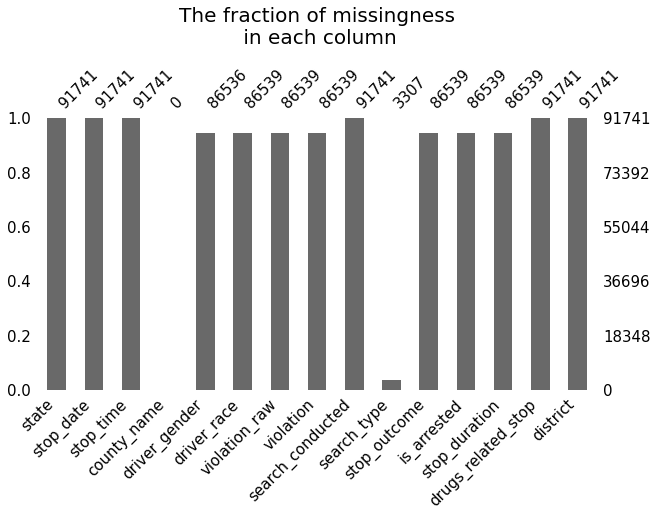

In [76]:
msno.bar(data, figsize=(10,5), fontsize=15)
plt.title("The fraction of missingness\n in each column", y=1.25, fontsize=20)
plt.show()

To make it easier, Let's drop ***country_name*** column and focus on the remaining columns.

In [77]:
data.drop(["county_name"], axis=1, inplace=True)

###### What about the missingness in ***search_type*** column !
***search_type*** column is a related field to ***search_conducted*** column and contains additional information about the search.

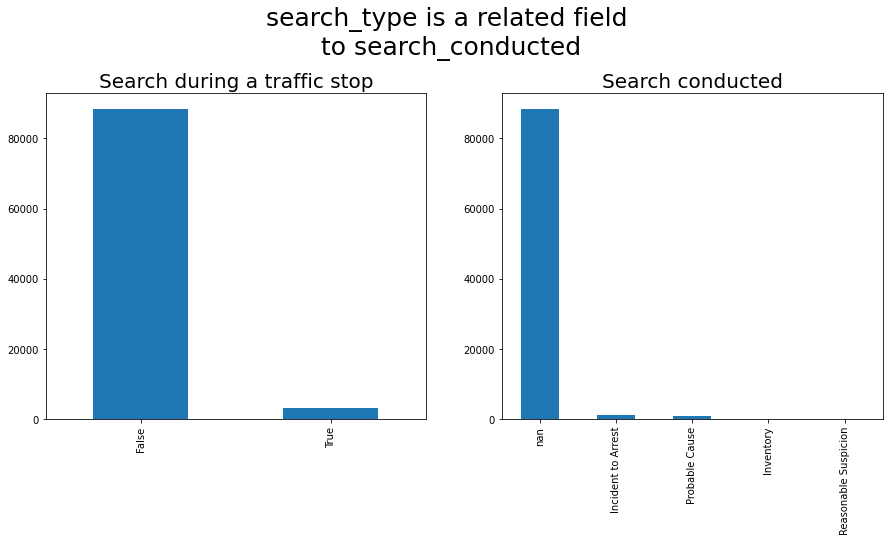

In [78]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

plt.subplot(1,2,1)
data.search_conducted.value_counts().plot(kind="bar")
#the search_conducted is True if there's a search during a traffic stop, and False otherwise. 
plt.title("Search during a traffic stop", fontsize=20)

plt.subplot(1,2,2)
data.search_type.value_counts(dropna=False).head(5).plot(kind="bar")
plt.title("Search conducted", fontsize=20)
#Note that the value_counts() method excludes missing values by default, 
#So we specified dropna equals False in order to see the missing values.

fig.suptitle("search_type is a related field \n to search_conducted ", y=1.08, fontsize=25)
plt.show()

Notice that the ***search_type*** field has ***83,229*** missing values, which is identical to the number of ***False values in the search_conducted*** field.

That's because any time a ***search is not conducted***, there's ***no information to record about a search***, and thus the ***search_type will be missing***.

So, we can describe missingness in search_type as ***missing-not-at-random***.

In [79]:
data["search_type"].replace(np.nan, value=False, inplace=True)

Let's dig deeper and find out more about missingness.

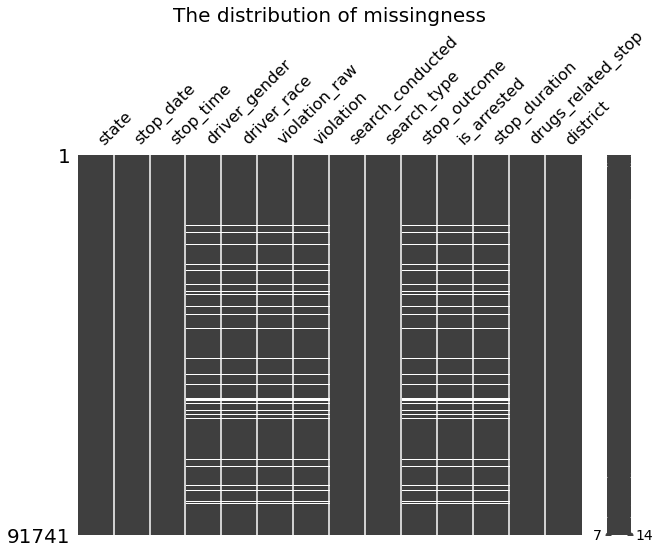

In [80]:
msno.matrix(data, figsize=(10,7))
plt.title("The distribution of missingness", fontsize=20)
plt.show()

###### As we can observe, We can describe the missigness in our dataset as ***missing not-at-random***, as there's a ***systmeic relationship*** between missingness, as ***missingness in the same samples***. 
###### ***Small fraction of rows are missingness***, So simply we're gonning to drop those rows.

In [81]:
data.dropna(subset=["driver_gender"], inplace=True)

Chech if there're any missingness.

In [82]:
data.isna().sum()

state                 0
stop_date             0
stop_time             0
driver_gender         0
driver_race           0
violation_raw         0
violation             0
search_conducted      0
search_type           0
stop_outcome          0
is_arrested           0
stop_duration         0
drugs_related_stop    0
district              0
dtype: int64

Now we have no missingness in our dataset.

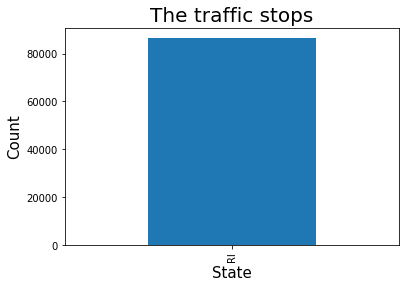

In [83]:
#sns.catplot(data= data, x="state", kind="count")
data["state"].value_counts().plot(kind="bar")
plt.title("The traffic stops", fontsize=20)
plt.ylabel("Count", fontsize=15)
plt.xlabel("State", fontsize=15)
plt.show()

***All the traffic stops*** took place in one state ***(Rhode Island)***. Thus, this column can be dropped, as it contains no useful information.

In [84]:
data.drop("state", axis=1, inplace=True)

#### ***Datatype constrains***
let's make sure that datatype is correct.


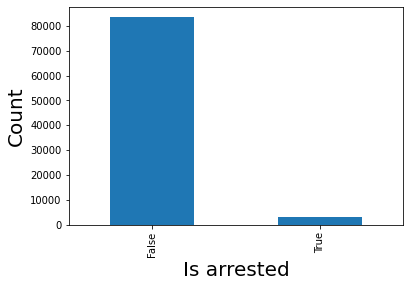

dtype('O')

In [85]:
data["is_arrested"].value_counts().plot(kind="bar")
plt.xlabel("Is arrested" , fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.show()

#get the datatype of is_arrested field
data["is_arrested"].dtypes

***is_arrested*** column is currently ***object datatype***. However it contains ***boolean vlues***. So, we'll change the datatype to ***bool***, which is the most suitable type for a column containing True and False values.

Fixing the data type will enable us to use ***mathematical operations*** on the is_arrested column that would not be possible otherwise.

In [86]:
data['is_arrested'] = data['is_arrested'].astype('bool')

## **Feature engineering**

***The date and time of each traffic stop*** are stored in separate object columns: ***stop_date and stop_time***.

We'll combine these two columns into a single column, then convert it to datetime format.

This will enable ***convenient date-based attributes***.

In [87]:
# Concatenate 'stop_date' and 'stop_time' and separated by a space
combined = data["stop_date"].str.cat(data["stop_time"], sep=' ')

# Convert 'combined' to datetime format, and add it as a new column.
data['stop_datetime'] = pd.to_datetime(combined)

Setting the index
By replacing the default index with a DatetimeIndex, you'll make it easier to analyze the dataset by date and time.

In [88]:
# Set 'stop_datetime' as the index
data.set_index('stop_datetime', inplace=True)

###### Now we can drop stop_date and stop_time.

In [89]:
data.drop(["stop_date", "stop_time"], axis=1, inplace=True)

In [90]:
data.head()

,driver_gender,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop,district
stop_datetime,,,,,,,,,,,
2005-01-04 12:55:00,M,White,Equipment/Inspection Violation,Equipment,False,False,Citation,False,0-15 Min,False,Zone X4
2005-01-23 23:15:00,M,White,Speeding,Speeding,False,False,Citation,False,0-15 Min,False,Zone K3
2005-02-17 04:15:00,M,White,Speeding,Speeding,False,False,Citation,False,0-15 Min,False,Zone X4
2005-02-20 17:15:00,M,White,Call for Service,Other,False,False,Arrest Driver,True,16-30 Min,False,Zone X1
2005-02-24 01:20:00,F,White,Speeding,Speeding,False,False,Citation,False,0-15 Min,False,Zone X3


## **Exploratory data analysis**.

#### ***Examining traffic violations***.
##### ***Does the gender of a driver have an impact on police behavior during a traffic stop?***.
Before comparing the ***violations being committed*** by each ***gender***, you should examine the violations committed by all drivers to get a baseline understanding of the data. 

First let's get the count of the unique values in the violation column, and separately express those counts as proportions.

In [ ]:
data["violation"].value_counts(normalize=True) *100

Speeding               55.957058
Moving violation       18.748267
Equipment              12.620181
Other                   5.094989
Registration/plates     4.279144
Seat belt               3.300361
Name: violation, dtype: float64

###### Interesting! More than half of all violations are for speeding, followed by other moving violations and equipment violations.

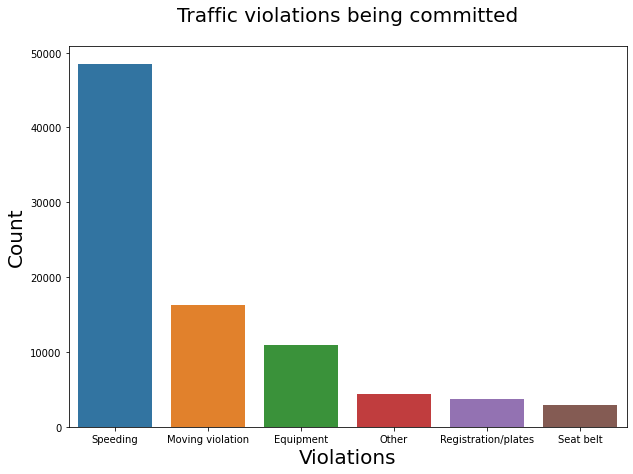

In [91]:
plt.figure(figsize=(10,7))
sns.countplot(x=data["violation"], 
              order=data["violation"].value_counts().index)
plt.title("Traffic violations being committed", y=1.05, fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Violations", fontsize=20)
plt.show()

###### ***Let's Compare violations by gender***
The question we're trying to answer is ***whether male and female drivers tend to commit different types of traffic violations or not***.

In [92]:
pd.DataFrame(data.groupby(['driver_gender']).violation.value_counts(normalize=True) *100 ).unstack()

violation                   ...                     
violation      Equipment Moving violation  ... Seat belt   Speeding
driver_gender                              ...                     
F              10.519896        13.821822  ...  2.431227  65.811391
M              13.415761        20.614385  ...  3.629585  52.224276

[2 rows x 6 columns]

About two-thirds of female traffic stops are for speeding, whereas stops of males are more balanced among the six categories. This doesn't mean that females speed more often than males, however, since we didn't take into account the number of stops or drivers.
##### ***For better intution, let's visualize it***.

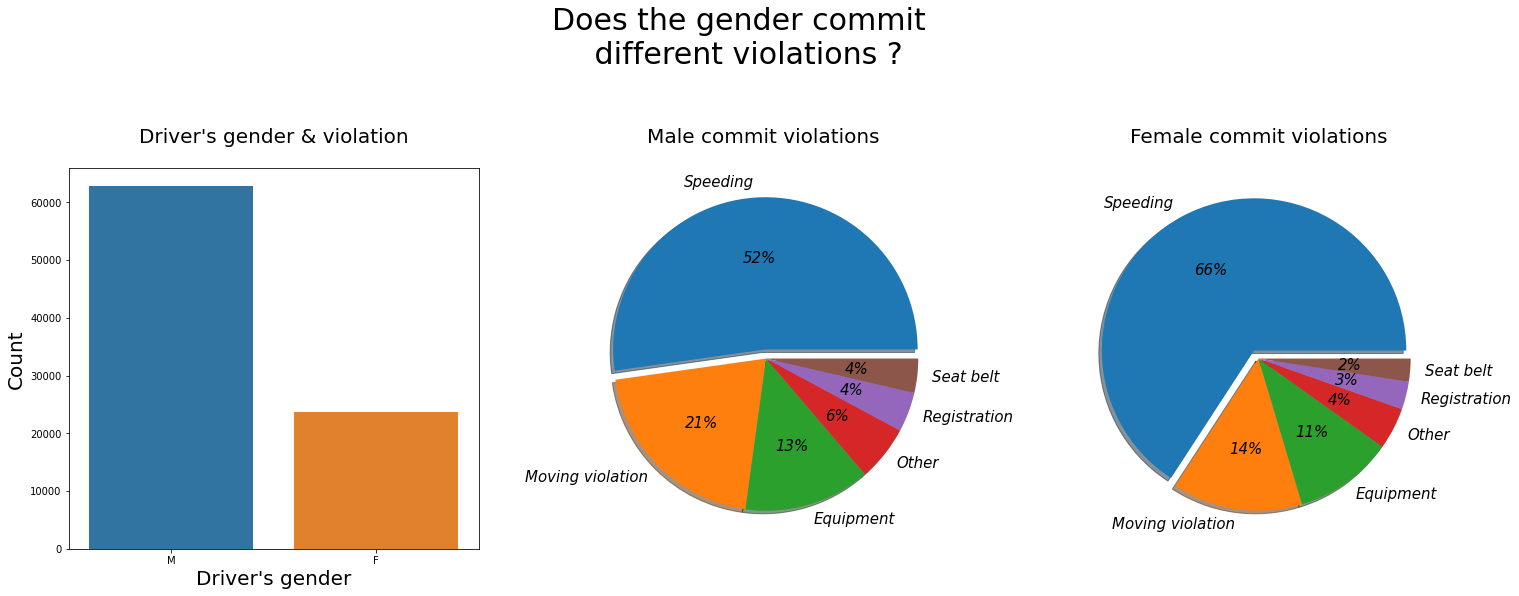

In [93]:
fig, ax = plt.subplots(1,2, figsize=(25,7))

plt.subplot(1,3,1)
sns.countplot(data= data, x= "driver_gender")
plt.title("Driver's gender & violation", y=1.05, fontsize=20)
plt.xlabel("Driver's gender", fontsize=20)
plt.ylabel("Count", fontsize=20)

plt.subplot(1,3,2)
plt.title("Male commit violations ", y=1.05, fontsize=20)
plt.pie(x=data[data["driver_gender"] == "M"].violation.value_counts(), 
        autopct="%1.f%%",
        explode=[0.06, 0, 0, 0, 0, 0],
        labels=["Speeding", "Moving violation", "Equipment", "Other", "Registration", "Seat belt"],
        shadow=True, textprops={"fontsize":15, "style":"italic"})

plt.subplot(1,3,3)
plt.title("Female commit violations", y=1.05, fontsize=20)
plt.pie(x= data[data["driver_gender"] == "F"].violation.value_counts(), 
        autopct="%1.f%%",
        explode=[0.06, 0, 0, 0, 0, 0],
        labels=["Speeding", "Moving violation", "Equipment", "Other", "Registration", "Seat belt"],
        shadow=True, textprops={"fontsize":15, "style":"italic"})

fig.suptitle("Does the gender commit \n different violations ?", y=1.2, fontsize=30)
plt.show()

Does gender affect who gets a ticket for speeding?

--- 

When a driver is pulled over for speeding, many people believe that gender has an impact on whether the driver will receive a ticket or a warning. Can you find evidence of this in the dataset?

First, you'll create two DataFrames of drivers who were stopped for speeding: one containing females and the other containing males.

Then, for each gender, you'll use the stop_outcome column to calculate what percentage of stops resulted in a "Citation" (meaning a ticket) versus a "Warning".

In [94]:
# Create a DataFrame of female drivers stopped for speeding
female_and_speeding = data[(data.driver_gender == 'F') & (data.violation == 'Speeding')]
# Create a DataFrame of male drivers stopped for speeding
male_and_speeding = data[(data.driver_gender == 'M') & (data.violation == 'Speeding')]

# Compute the stop outcomes for female drivers (as proportions)
df1 = male_and_speeding["stop_outcome"].value_counts(normalize=True) *100

# Compute the stop outcomes for male drivers (as proportions)
df2 = female_and_speeding["stop_outcome"].value_counts(normalize=True) * 100

pd.DataFrame(data=(df1, df2), index=["Male_speed", "Female_speed"])

,Citation,Warning,Arrest Driver,Arrest Passenger,No Action,N/D
Male_speed,94.459530,3.618391,1.589529,0.128139,0.106782,0.097629
Female_speed,95.219225,4.007414,0.575227,0.063914,0.038348,0.095871


Interesting! The numbers are similar for males and females: about 95% of stops for speeding result in a ticket. 

The data fails to show that gender has an impact on who gets a ticket for speeding.

what about driver's race !

***Does the driver's race affect on the stop outcome?***

---

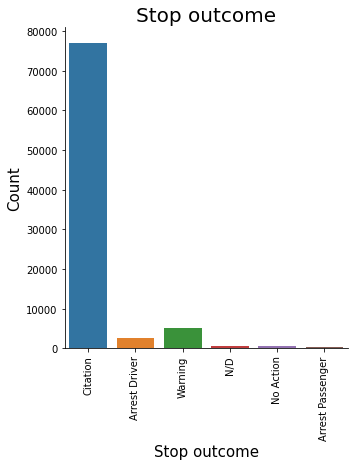

In [95]:
sns.catplot(data=data, x="stop_outcome", kind="count")
plt.title("Stop outcome", fontsize=20)
plt.xlabel("Stop outcome", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.xticks(rotation=90)
plt.show()

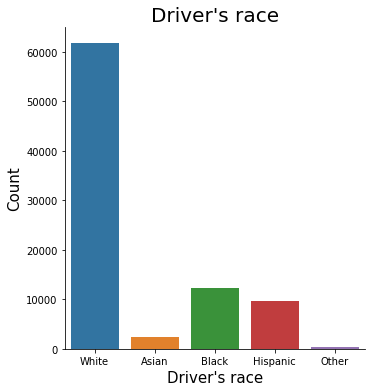

In [96]:
sns.catplot(data=data, x="driver_race", kind="count")
plt.title("Driver's race", fontsize=20)
plt.xlabel("Driver's race", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

In [97]:
pd.DataFrame(data.groupby(['driver_race']).stop_outcome.value_counts(normalize=True) *100 ).unstack()

stop_outcome                   ...                    
stop_outcome Arrest Driver Arrest Passenger  ... No Action   Warning
driver_race                                  ...                    
Asian             1.758058         0.167434  ...  0.837170  4.520720
Black             5.429385         0.830281  ...  0.651201  6.512007
Hispanic          5.530996         0.688804  ...  0.884137  6.744114
Other             0.754717              NaN  ...  1.132075  5.283019
White             2.401810         0.274770  ...  0.703087  5.750768

[5 rows x 6 columns]

***Black and hispanic drivers*** are arrested at ***heigher rate*** than white and asian.

##### During a traffic stop, the police officer sometimes conducts a search of the vehicle. 
The impornt question is, ***Does gender affect whose vehicle is searched ?***
###### Let's first find out the portion of the vehicles that's searched.

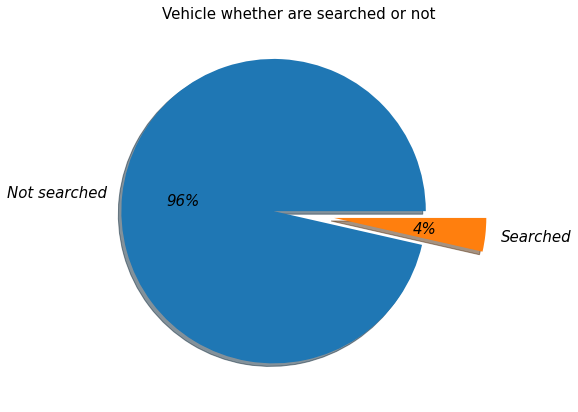

In [98]:
plt.figure(figsize=(15,7))
plt.title("Vehicle whether are searched or not  ", fontsize=15)
plt.pie(data["is_arrested"].value_counts(), autopct="%1.f%%",
        labels=["Not searched", "Searched"],
        explode=[0.2, 0.2],
        shadow=True, textprops={"fontsize":15, "style":"italic"} )
plt.show()

Let's compare the rates at which female and male drivers are searched during a traffic stop

In [99]:
arrested = data[data["is_arrested" ] == True]
arrested["driver_gender"].value_counts(normalize=True)

M    0.782651
F    0.217349
Name: driver_gender, dtype: float64

Well, It seems that gender affects the vechicle that's searched. As, About 79% of arrested drivers were men, and 21% were women.

In [100]:
pd.DataFrame(data.groupby(by="driver_gender").is_arrested.value_counts(normalize=True)*100).unstack()

is_arrested          
is_arrested         False     True 
driver_gender                      
F               97.186002  2.813998
M               96.161690  3.838310

Males are arrested at heigher rate than female.
###### ***for better intution, Let's visualize it***.

<Figure size 1080x504 with 0 Axes>

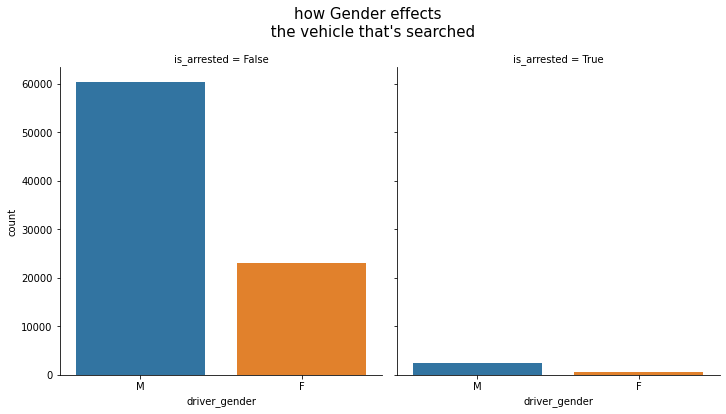

In [101]:
plt.figure(figsize=(15,7))
sns.catplot(data= data, x="driver_gender", col="is_arrested", kind="count")

plt.suptitle("how Gender effects \n the vehicle that's searched", y=1.1, fontsize=15)

plt.show()

In [102]:
pd.DataFrame(data.groupby(['driver_race']).is_arrested.value_counts(normalize=True) *100 ).unstack()

is_arrested          
is_arrested       False     True 
driver_race                      
Asian         98.074508  1.925492
Black         93.740334  6.259666
Hispanic      93.780199  6.219801
Other         99.245283  0.754717
White         97.323420  2.676580

***Black and hispanic drivers*** are searched at a heigher rate than ***white and asian***.

In [103]:
pd.DataFrame(data.groupby(['driver_race', 'driver_gender']).is_arrested.value_counts(normalize=True) *100 )

is_arrested
driver_race driver_gender is_arrested             
Asian       F             False          98.003630
                          True            1.996370
            M             False          98.095756
                          True            1.904244
Black       F             False          93.659082
                          True            6.340918
            M             False          93.763015
                          True            6.236985
Hispanic    F             False          94.930876
                          True            5.069124
            M             False          93.491124
                          True            6.508876
Other       F             False         100.000000
            M             False          99.056604
                          True            0.943396
White       F             False          97.901381
                          True            2.098619
            M             False          97.076199
                          True            2.923801

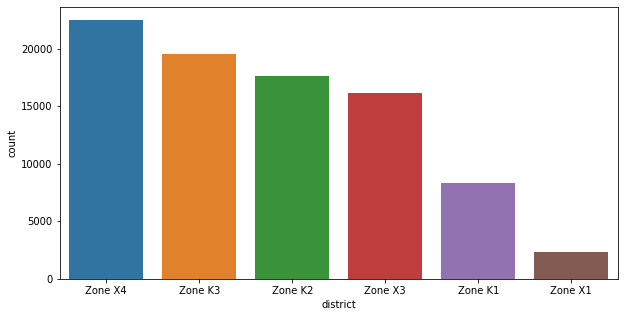

In [104]:
plt.figure(figsize=(10,5))
sns.countplot(x= data["district"],
              order=data["district"].value_counts().index)
#data["district"].value_counts().sort_values().plot(kind="bar")
plt.show()

##### As we can see Zone X4 is the most fequent disrict in our dataset.
##### Let's find our more, if district effects on vehicle that's searched.

In [105]:
pd.DataFrame(data.groupby("district").is_arrested.mean() *100)

,is_arrested
district,
Zone K1,2.434908
Zone K2,3.080059
Zone K3,3.231084
Zone X1,2.349423
Zone X3,3.487078
Zone X4,4.803804


You can see a noticeably ***higher arrest rate in Zone X4 district***, ather district are very closely in numbers.
Let's compute the arrest rate for every combination of district and gender. In other words, you can see the arrest rate for males and females in each district separately.

In [106]:
pd.DataFrame(data.groupby(['driver_gender', 'district']).is_arrested.value_counts(normalize= True)*100).unstack()

is_arrested          
is_arrested                  False     True 
driver_gender district                      
F             Zone K1    98.083067  1.916933
              Zone K2    97.780397  2.219603
              Zone K3    97.484396  2.515604
              Zone X1    98.035363  1.964637
              Zone X3    97.281153  2.718847
              Zone X4    95.785094  4.214906
M             Zone K1    97.341160  2.658840
              Zone K2    96.571474  3.428526
              Zone K3    96.503888  3.496112
              Zone X1    97.543668  2.456332
              Zone X3    96.183408  3.816592
              Zone X4    95.004418  4.995582


Even though the search rate for males is much higher than for females, it's possible that the difference is mostly due to a second factor.

For example, you might hypothesize that the search rate varies by violation type, and the difference in search rate between males and females is because they tend to commit different violations.

You can test this hypothesis by examining the search rate for each combination of gender and violation. If the hypothesis was true, you would find that males and females are searched at about the same rate for each violation. Find out below if that's the case!

***Does gender affect who is frisked during a search?***

---

Counting protective frisks, During a vehicle search, the police officer may pat down the driver to check if they have a weapon. This is known as a "protective frisk."

We'll first check to see how many times "Protective Frisk" was the only search type. 

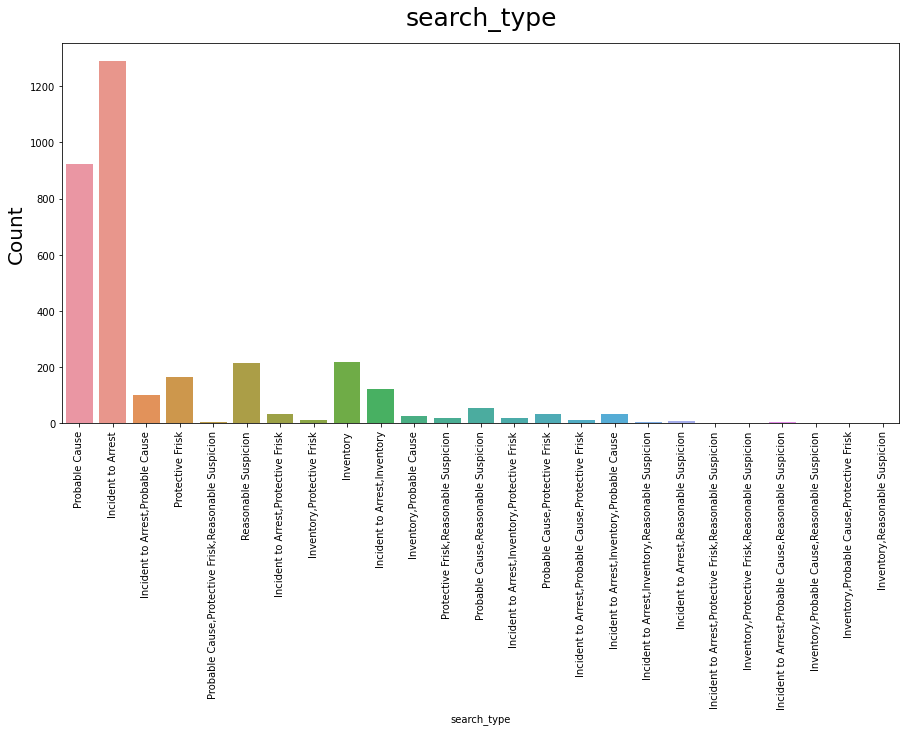

In [107]:
plt.figure(figsize=(15,7))
sns.countplot(data=data[-(data["search_type"] == False)], x="search_type")

plt.title("search_type", y=1.03, fontsize=25)
plt.ylabel("Count", fontsize=20)
plt.xticks(rotation=90)
plt.show()

In [108]:
# Check if 'search_type' contains the string 'Frisk'
data['frisk'] = data["search_type"].str.contains('Frisk', na=False)
# Take the sum of 'frisk'
data["frisk"].sum()

303

It looks like there were 303 drivers who were frisked

Comparing frisk rates by gender

We'll compare the rates at which female and male drivers are frisked during a search. Are males frisked more often than females, perhaps because police officers consider them to be higher risk?

Before doing any calculations, it's important to filter the DataFrame to only include the relevant subset of data, namely stops in which a search was conducted.

In [109]:
# Create a DataFrame of stops in which a search was conducted
searched = data[data["search_conducted"] == True]

# Calculate the frisk rate for each gender
pd.DataFrame(searched.groupby('driver_gender').frisk.mean() * 100)

,frisk
driver_gender,
F,7.456140
M,9.435286


Interesting! The frisk rate is higher for males than for females, though we can't conclude that this difference is caused by the driver's gender.

In [110]:
pd.DataFrame(data.groupby("driver_race").frisk.value_counts(normalize=True)*100).unstack()

frisk          
frisk             False     True 
driver_race                      
Asian         99.832566  0.167434
Black         99.462759  0.537241
Hispanic      99.609335  0.390665
Other        100.000000       NaN
White         99.684823  0.315177

Black drivers are put down at a heigher rate.

Does time of day affect arrest rate?

---

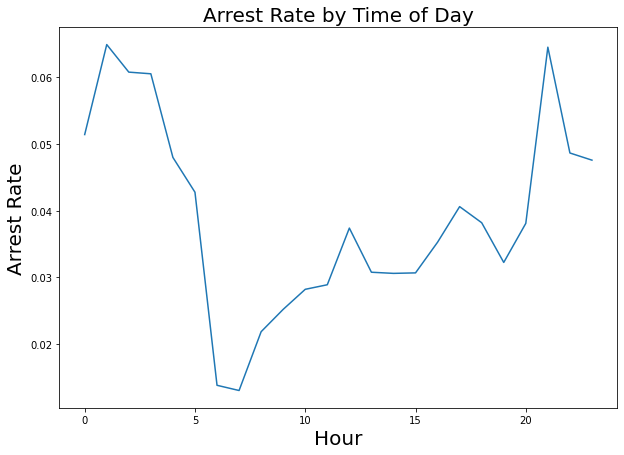

In [111]:
# Save the hourly arrest rate
hourly_arrest_rate = data.groupby(data.index.hour).is_arrested.mean()

plt.figure(figsize=(10,7))
hourly_arrest_rate.plot()

plt.xlabel('Hour', fontsize=20)
plt.ylabel('Arrest Rate', fontsize=20)
plt.title('Arrest Rate by Time of Day', fontsize=20)

plt.show()

#### The arrest rate has a significant spike overnight, and then dips in the early morning hours.

Are drug-related stops on the rise?

---

In a small portion of traffic stops, drugs are found in the vehicle during a search.

We'll assess whether these drug-related stops are becoming more common over time.

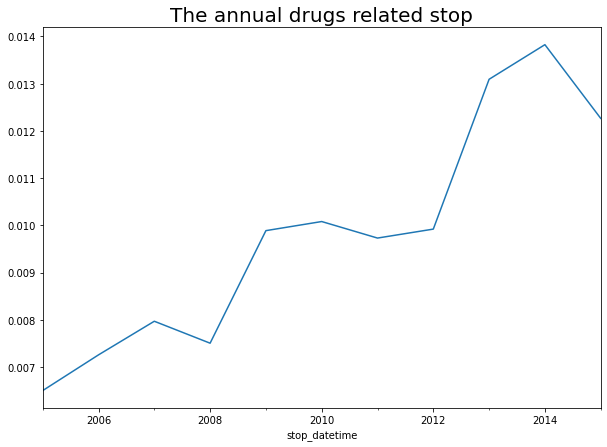

In [112]:
# Save the annual rate of drug-related stops
annual_drug_rate = data["drugs_related_stop"].resample('A').mean()

plt.figure(figsize=(10,7))
# Create a line plot of 'annual_drug_rate'
annual_drug_rate.plot()
plt.title("The annual drugs related stop", fontsize=20)
# Display the plot
plt.show()

##### Interesting! The rate of drug-related stops nearly doubled over the course of 10 years. Why might that be the case?
the rate of drug-related stops increased significantly between 2005 and 2015. 

You might hypothesize that the rate of vehicle searches was also increasing, which would have led to an increase in drug-related stops even if more drivers were not carrying drugs.

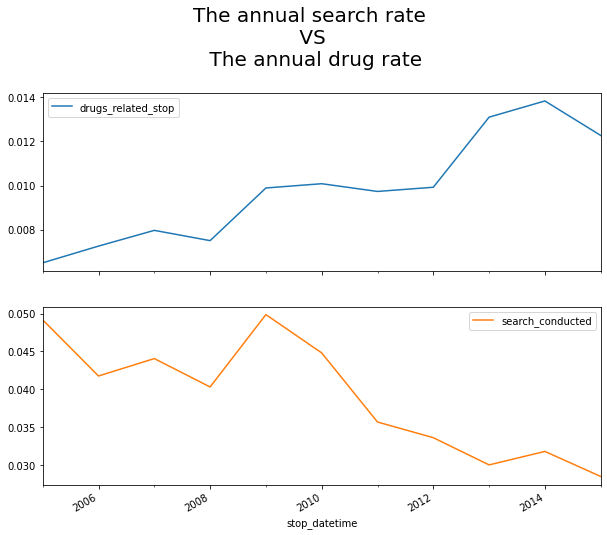

In [113]:
# Calculate and save the annual search rate
annual_search_rate = data["search_conducted"].resample('A').mean()

# Concatenate 'annual_drug_rate' and 'annual_search_rate'
annual = pd.concat([annual_drug_rate, annual_search_rate], axis='columns')

# Create subplots from 'annual'
annual.plot(subplots=True, figsize=(10,8))
plt.suptitle("The annual search rate \n VS \n The annual drug rate", y=1.03, fontsize=20)

plt.show()

The rate of drug-related stops increased even though the search rate decreased, ***disproving our hypothesis***.

What violations are caught in each district?

---
Tallying violations by district

The state of Rhode Island is broken into six police districts, also known as zones. How do the zones compare in terms of what violations are caught by police?

We'll create a frequency table to determine how many violations of each type took place in each of the six zones.

In [114]:
# Save the frequency table as 'all_zones'
all_zones = pd.crosstab(data.district, data.violation)
all_zones

violation,Equipment,Moving violation,Other,Registration/plates,Seat belt,Speeding
district,,,,,,
Zone K1,672,1254,290,120,0,5960
Zone K2,2061,2962,942,768,481,10448
Zone K3,2302,2898,705,695,638,12322
Zone X1,296,671,143,38,74,1119
Zone X3,2049,3086,769,671,820,8779
Zone X4,3541,5353,1560,1411,843,9795


<Figure size 720x1080 with 0 Axes>

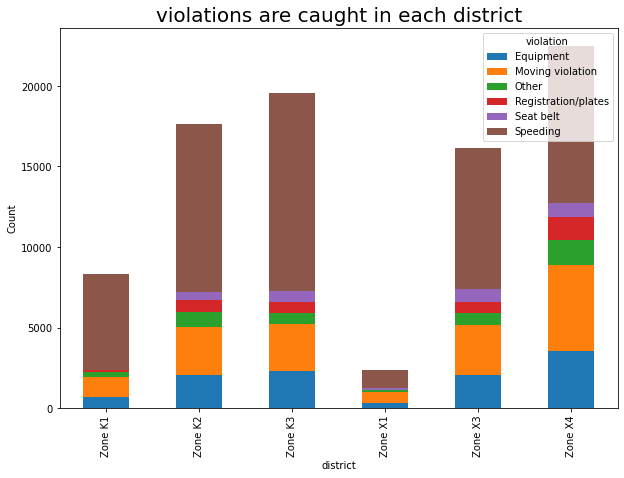

In [115]:
plt.figure(figsize=(10,15))

all_zones.plot(kind='bar', stacked=True, figsize=(10,7))

plt.title("violations are caught in each district", fontsize=20)
plt.ylabel("Count")
plt.xlabel("district")
plt.show()

Interesting! The vast majority of traffic stops in Zone K1 are for speeding, and Zones K2 and K3 are remarkably similar to one another in terms of violations.

In [116]:
pd.crosstab(data["driver_race"], data["driver_gender"])

driver_gender,F,M
driver_race,,
Asian,551,1838
Black,2681,9604
Hispanic,1953,7774
Other,53,212
White,18536,43334


How long might you be stopped for a violation?

---

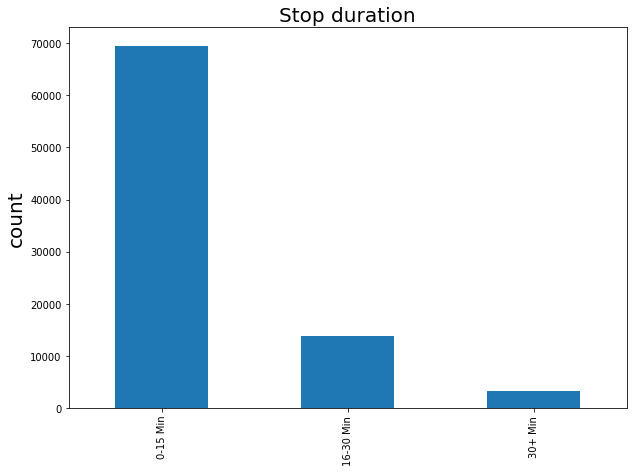

In [117]:
# Print the unique values in 'stop_duration'
plt.figure(figsize=(10,7))
data["stop_duration"].value_counts().plot(kind="bar")
plt.title("Stop duration", fontsize=20)
plt.ylabel("count", fontsize=20)
plt.show()

the stop_duration column tells you approximately how long the driver was detained by the officer. Unfortunately, the durations are stored as strings, such as '0-15 Min'.

Most vehicles have been stoped 0-15 Min. 

We'll convert the stop durations to integers. Because the precise durations are not available, you'll have to estimate the numbers using reasonable values:

    Convert '0-15 Min' to 8
    Convert '16-30 Min' to 23
    Convert '30+ Min' to 45


In [118]:
mapping = {'0-15 Min':8, '16-30 Min':23, '30+ Min':45}

# Convert the 'stop_duration' strings to integers using the 'mapping'
data['stop_minutes'] = data.stop_duration.map(mapping)

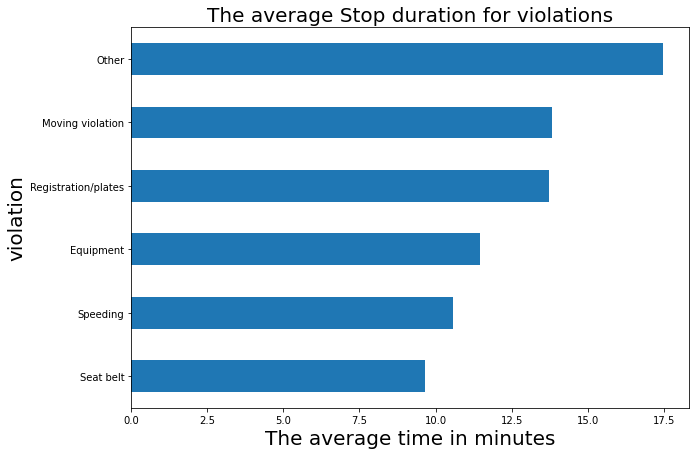

In [119]:
# Calculate the mean 'stop_minutes' for each value in 'violation_raw'
stop_length = data.groupby('violation').stop_minutes.mean()

plt.figure(figsize=(10,7))
# Sort 'stop_length' by its values and create a horizontal bar plot
stop_length.sort_values().plot(kind='barh')
plt.title("The average Stop duration for violations", fontsize=20)
plt.ylabel("violation", fontsize=20)
plt.xlabel("The average time in minutes", fontsize=20)
# Display the plot
plt.show()